# Assignment - 3

# 2022121008

# Prakhar Jain

**Conext**

**Cityscapes data** contains labeled videos taken from vehicles driven in Germany. This version is a processed subsample created as part of the [Pix2Pix](https://phillipi.github.io/pix2pix/) paper. The dataset has still images from the original videos, and the semantic segmentation labels are shown in images alongside the original image. This is one of the best datasets around for semantic segmentation tasks.

**Content**

This dataset has 2975 training images files and 500 validation image files. Each image file is 256x512 pixels, and each file is a composite with the original photo on the left half of the image, alongside the labeled image (output of semantic segmentation) on the right half.

**Dataset:** 

https://www.kaggle.com/dansbecker/cityscapes-image-pairs

**References:** 

*   https://arxiv.org/pdf/1603.07285v1.pdf
*   https://towardsdatascience.com/u-net-b229b32b4a71



### 1. [1 point] Preparation. 
We will use an existing illustrative code for segmentation using a Unet in Pytorch.


Please make a copy of the following notebook as a google colab project and ensure you are able to run it:

`https://www.kaggle.com/code/dhvananrangrej/image-segmentation-with-unet-pytorch/notebook`

The first cell should contain the necessary code to download the segmentation dataset (a subset of Cityscapes).

Carefully study the code, especially focusing on the data and model.

Do not change the model definition, dataset class, or evaluation metric (currently being computed over 10 images
or 1 batch of the validation set). You may need to fix one bug `iter(data_loader).next()`, but this does not influence the other parts.

Hint: You may train the model for 1 epoch as it takes quite some time to complete all 10 epochs.

In [1]:

import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from pathlib import Path

from tqdm.auto import tqdm

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


### 2. Configure data locations

In [3]:
data_dir = Path("cityscapes_data")
train_dir = data_dir / "train"
val_dir = data_dir / "val"


# data_dir = os.path.join("/kaggle", "input", "cityscapes-image-pairs", "cityscapes_data")
# train_dir = os.path.join(data_dir, "train") 
# val_dir = os.path.join(data_dir, "val")


train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)

print(len(train_fns), len(val_fns))
# print(f"Train Directory : {train_dir}")
# print(f"Validation Directory : {val_dir}")

2975 500


### 3. Analyze data

cityscapes_data/train/936.jpg


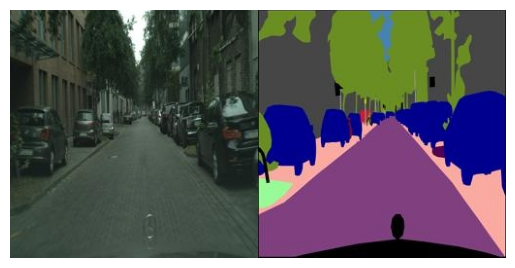

In [4]:
# sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image_fp = train_dir / train_fns[0]


sample_image = Image.open(sample_image_fp).convert("RGB")

plt.imshow(sample_image)
plt.axis("off")

print(sample_image_fp)

### 4. Extract Image and Labels

The input images contain both the road scene and the corresponding label in the same image. Thus, we are splitting it and presenting it as two separate entities.

In [5]:
def split_image(image):
  image = np.array(image)
  # print(image.shape)
  cityscape, label = image[:, :256, :], image[:, 256:, :]
  return cityscape, label

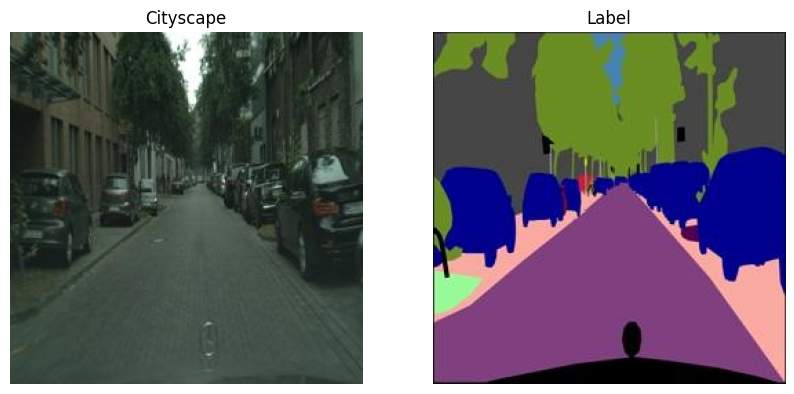

In [6]:
sample_image = np.array(sample_image)
cityscape, label = split_image(sample_image)

# display split images
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(cityscape)
axes[0].axis("off")
axes[0].set_title("Cityscape")
axes[1].imshow(label)
axes[1].axis("off")
axes[1].set_title("Label")
plt.show()

### 5. Define Labels

We use K-means clustering to segregate the objects of different colors and assign them class labels.   

In [7]:
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1,3)
print(color_array.shape)

(1000, 3)


In [8]:
num_classes = 10
label_model = KMeans(n_clusters = num_classes)
label_model.fit(color_array)

KMeans(n_clusters=10)

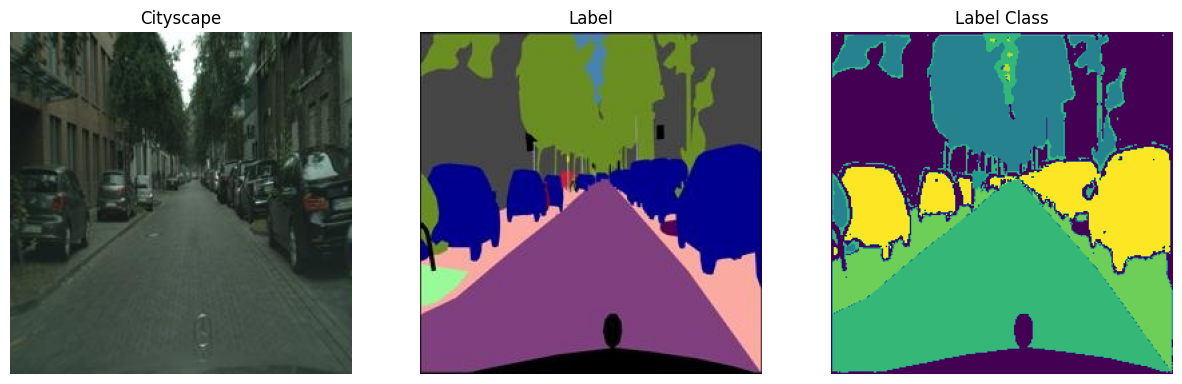

In [9]:
cityscape, label = split_image(sample_image)
label_class = label_model.predict(label.reshape(-1,3)).reshape(256,256)
fig, axes = plt.subplots(1,3,figsize=(15,5))
# plt.axis('off')
axes[0].imshow(cityscape)
axes[0].set_title('Cityscape')
axes[0].axis('off')
axes[1].imshow(label)
axes[1].set_title('Label')
axes[1].axis('off')
axes[2].imshow(label_class)
axes[2].set_title('Label Class')
axes[2].axis('off')
plt.show()

In [10]:
# label_class

### 6. Define Dataset

In [11]:
class CityscapeDataset(Dataset):

  def __init__(self, image_dir, label_model):
    self.image_dir = image_dir
    self.image_fns = os.listdir(image_dir)
    self.label_model = label_model

  def __len__(self):
    return len(self.image_fns)
  
  def __getitem__(self, index):
    image_fn = self.image_fns[index]
    image_fp = os.path.join(self.image_dir, image_fn)
    image = Image.open(image_fp).convert("RGB")
    image = np.array(image)
    cityscape, label = self.split_image(image)
    label_class = self.label_model.predict(label.reshape(-1,3)).reshape(256,256)
    label_class = torch.Tensor(label_class).long()
    cityscape = self.transform(cityscape)
    return cityscape, label_class

  def split_image(self, image):
    image = np.array(image)
    cityscape, label = image[:, :256, :], image[:, 256:, :]
    return cityscape, label
  
  def transform(self, image):
    transform_ops = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=(0.485, 0.56, 0.406), std=(0.229, 0.224, 0.225))
    ])
    return transform_ops(image)

In [12]:
dataset = CityscapeDataset(train_dir, label_model)
print(len(dataset))

2975


In [13]:
cityscape, label_class= dataset[0]
print(cityscape.shape, label_class.shape)

torch.Size([3, 256, 256]) torch.Size([256, 256])


### 7. Define Model 


In [14]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [17]:
model = UNet(num_classes = num_classes)

In [14]:
data_loader = DataLoader(dataset, batch_size = 4)
print(len(dataset), len(data_loader))

data_iter = iter(data_loader)
X, Y = next(data_iter)
print(X.shape, Y.shape)

2975 744
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])


In [17]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([4, 10, 256, 256])


### 8. Train the model

In [ ]:
batch_size = 16

epochs = 10
lr = 0.01

In [19]:
dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)

# model here

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

step_losses = []
epoch_losses = []

for epoch in tqdm(range(epochs)):
  epoch_loss = 0
  for X,Y in tqdm(data_loader, total=len(data_loader), leave = False):
    X, Y = X.to(device), Y.to(device)
    optimizer.zero_grad()
    Y_pred = model(X)
    loss = criterion(Y_pred, Y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    step_losses.append(loss.item())
  epoch_losses.append(epoch_loss/len(data_loader))

In [20]:
model = UNet(num_classes = num_classes).to(device)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

In [23]:
step_losses = []
epoch_losses = []

for epoch in tqdm(range(epochs)):
  epoch_loss = 0
  for X,Y in tqdm(data_loader, total=len(data_loader), leave = False):
    X, Y = X.to(device), Y.to(device)
    optimizer.zero_grad()
    Y_pred = model(X)
    loss = criterion(Y_pred, Y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    step_losses.append(loss.item())
  epoch_losses.append(epoch_loss/len(data_loader))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

In [24]:
# dump step_losses and epoch_losses to a npy file
np.save("step_losses.npy", np.array(step_losses))
np.save("epoch_losses.npy", np.array(epoch_losses))


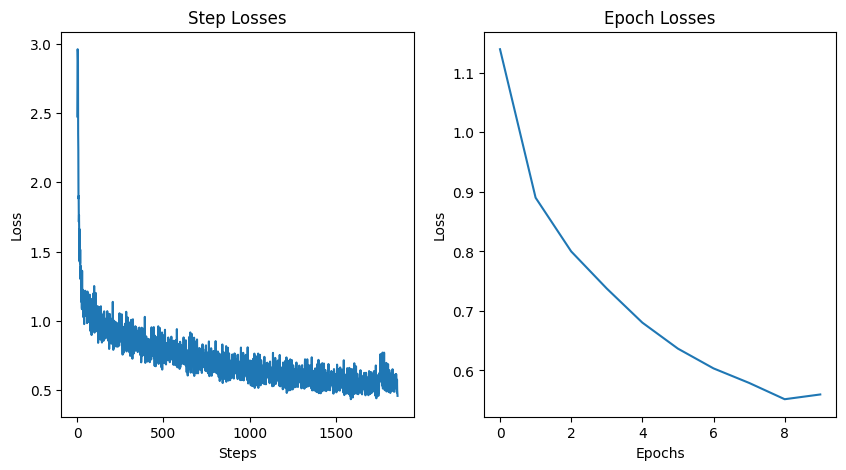

In [28]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].plot(step_losses)
axes[0].set_xlabel("Steps")
axes[0].set_ylabel("Loss")
axes[0].set_title("Step Losses")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].set_title("Epoch Losses")
axes[1].plot(epoch_losses)
plt.show()

In [26]:
model_name = "U-Net.pth"
torch.save(model.state_dict(), model_name)

### 9. Check model predictions

In [40]:
model_path = "U-Net.pth"
model_ = UNet(num_classes=num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [41]:
test_batch_size = 10
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

In [42]:
X,Y = next(iter(data_loader))
X,Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([10, 10, 256, 256])
torch.Size([10, 256, 256])


In [43]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

In [44]:
def compute_iou(pred, true, num_classes):
    iou_list = []
    for cls in range(num_classes):
        pred_idx = (pred == cls)
        true_idx = (true == cls)
        intersection = np.logical_and(pred_idx, true_idx).sum()
        union = np.logical_or(pred_idx, true_idx).sum()

        if union == 0:
            if intersection == 0:
                iou_list.append(1)
        else : 
            iou_list.append(intersection / union)
    return np.nanmean(iou_list)
            

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Image : 0 | Mean IOU : 0.1185712605266035
Image : 1 | Mean IOU : 0.12843126850455427
Image : 2 | Mean IOU : 0.12480011182449105
Image : 3 | Mean IOU : 0.13241715984493863
Image : 4 | Mean IOU : 0.2574710972416604
Image : 5 | Mean IOU : 0.14896768955480635
Image : 6 | Mean IOU : 0.1352525292681012
Image : 7 | Mean IOU : 0.1397890371965409
Image : 8 | Mean IOU : 0.11783540507444186
Image : 9 | Mean IOU : 0.1317778347508502


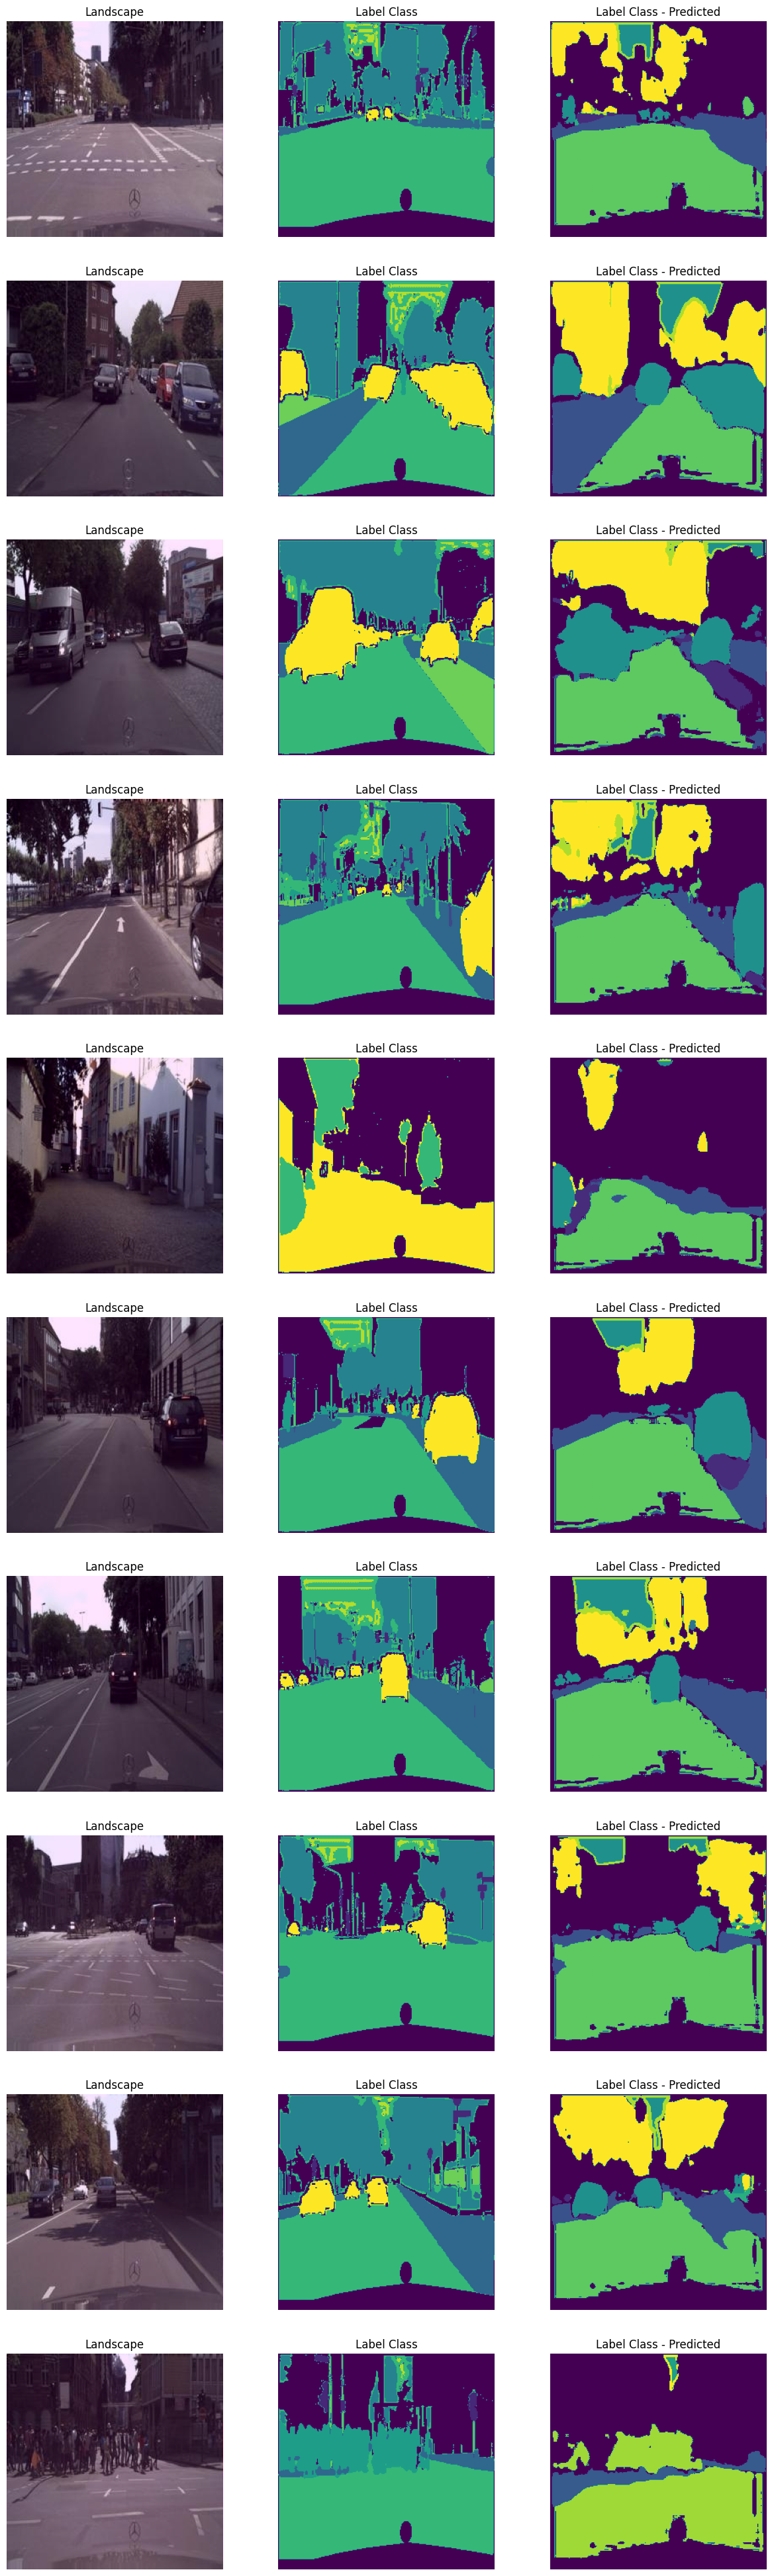

In [45]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

iou_scores = []

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    
    # print(f'{i} | Mean IoU: {compute_iou(label_class_predicted, label_class, num_classes)}')
    iou_score = compute_iou(label_class_predicted, label_class, num_classes)
    print(f"Image : {i} | Mean IOU : {iou_score}")
    iou_scores.append(iou_score)
    # IOU score
    # intersection = np.logical_and(label_class, label_class_predicted)
    # union = np.logical_or(label_class, label_class_predicted)
    # iou_score = np.sum(intersection) / np.sum(union)
    # iou_scores.append(iou_score)

    axes[i, 0].imshow(landscape)
    axes[i, 0].axis('off')
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].axis('off')
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].axis('off')
    axes[i, 2].set_title("Label Class - Predicted")


In [46]:
print(f"Mean IOU Score : {np.mean(iou_scores)}")

Mean IOU Score : 0.14353133937869883


# Without skip connections

In [47]:
class UNetNoSkipConnections(nn.Module):
    
    def __init__(self, num_classes):
        super(UNetNoSkipConnections, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        # self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_12 = self.conv_block(in_channels=512, out_channels=512)
        
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        # self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_22 = self.conv_block(in_channels=256, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        # self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_32 = self.conv_block(in_channels=128, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        # self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.expansive_42 = self.conv_block(in_channels=64, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(expansive_11_out) # [-1, 512, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(expansive_21_out) # [-1, 256, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(expansive_31_out) # [-1, 128, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(expansive_41_out) # [-1, 64, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [32]:
batch_size = 16

epochs = 10
lr = 0.01

In [41]:
dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)

In [42]:
model = UNetNoSkipConnections(num_classes = num_classes).to(device)

In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

In [44]:
step_losses = []
epoch_losses = []

for epoch in tqdm(range(epochs)):
  epoch_loss = 0
  for X,Y in tqdm(data_loader, total=len(data_loader), leave = False):
    X, Y = X.to(device), Y.to(device)
    optimizer.zero_grad()
    Y_pred = model(X)
    loss = criterion(Y_pred, Y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    step_losses.append(loss.item())
  epoch_losses.append(epoch_loss/len(data_loader))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

In [45]:
# dump step_losses and epoch_losses to a npy file
np.save("step_losses_no_skip_connections.npy", np.array(step_losses))
np.save("epoch_losses_no_skip_connections.npy", np.array(epoch_losses))


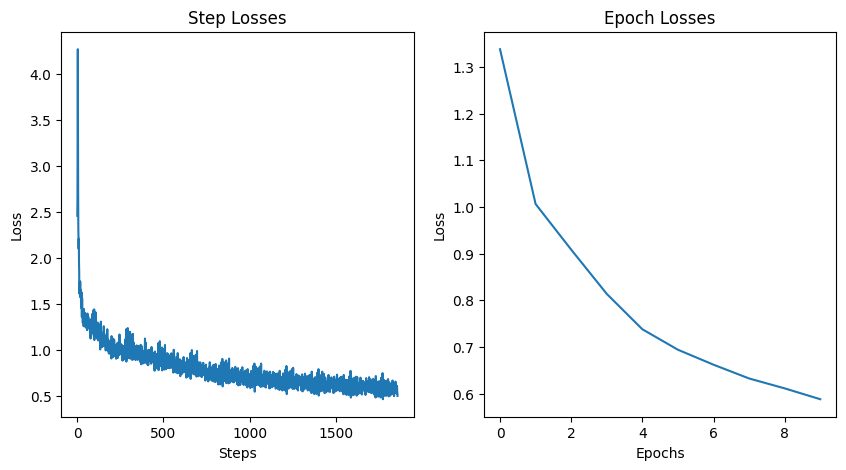

In [46]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].plot(step_losses)
axes[0].set_xlabel("Steps")
axes[0].set_ylabel("Loss")
axes[0].set_title("Step Losses")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].set_title("Epoch Losses")
axes[1].plot(epoch_losses)
plt.show()

In [73]:
model_name = "U-Net-no-skip-connection.pth"
torch.save(model.state_dict(), model_name)

In [48]:
model_path = "U-Net-no-skip-connection.pth"
model_ = UNetNoSkipConnections(num_classes=num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [49]:
test_batch_size = 10
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

In [50]:
X,Y = next(iter(data_loader))
X,Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([10, 10, 256, 256])
torch.Size([10, 256, 256])


In [51]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Image : 0 | Mean IOU : 0.005375088589045418
Image : 1 | Mean IOU : 0.004997069117719344
Image : 2 | Mean IOU : 0.02348928428892786
Image : 3 | Mean IOU : 0.005404399154679001
Image : 4 | Mean IOU : 0.10061546624220719
Image : 5 | Mean IOU : 0.0018673309473233562
Image : 6 | Mean IOU : 0.0018809449981096256
Image : 7 | Mean IOU : 0.002369906787075618
Image : 8 | Mean IOU : 0.0025577032009195056
Image : 9 | Mean IOU : 0.001419412818926232


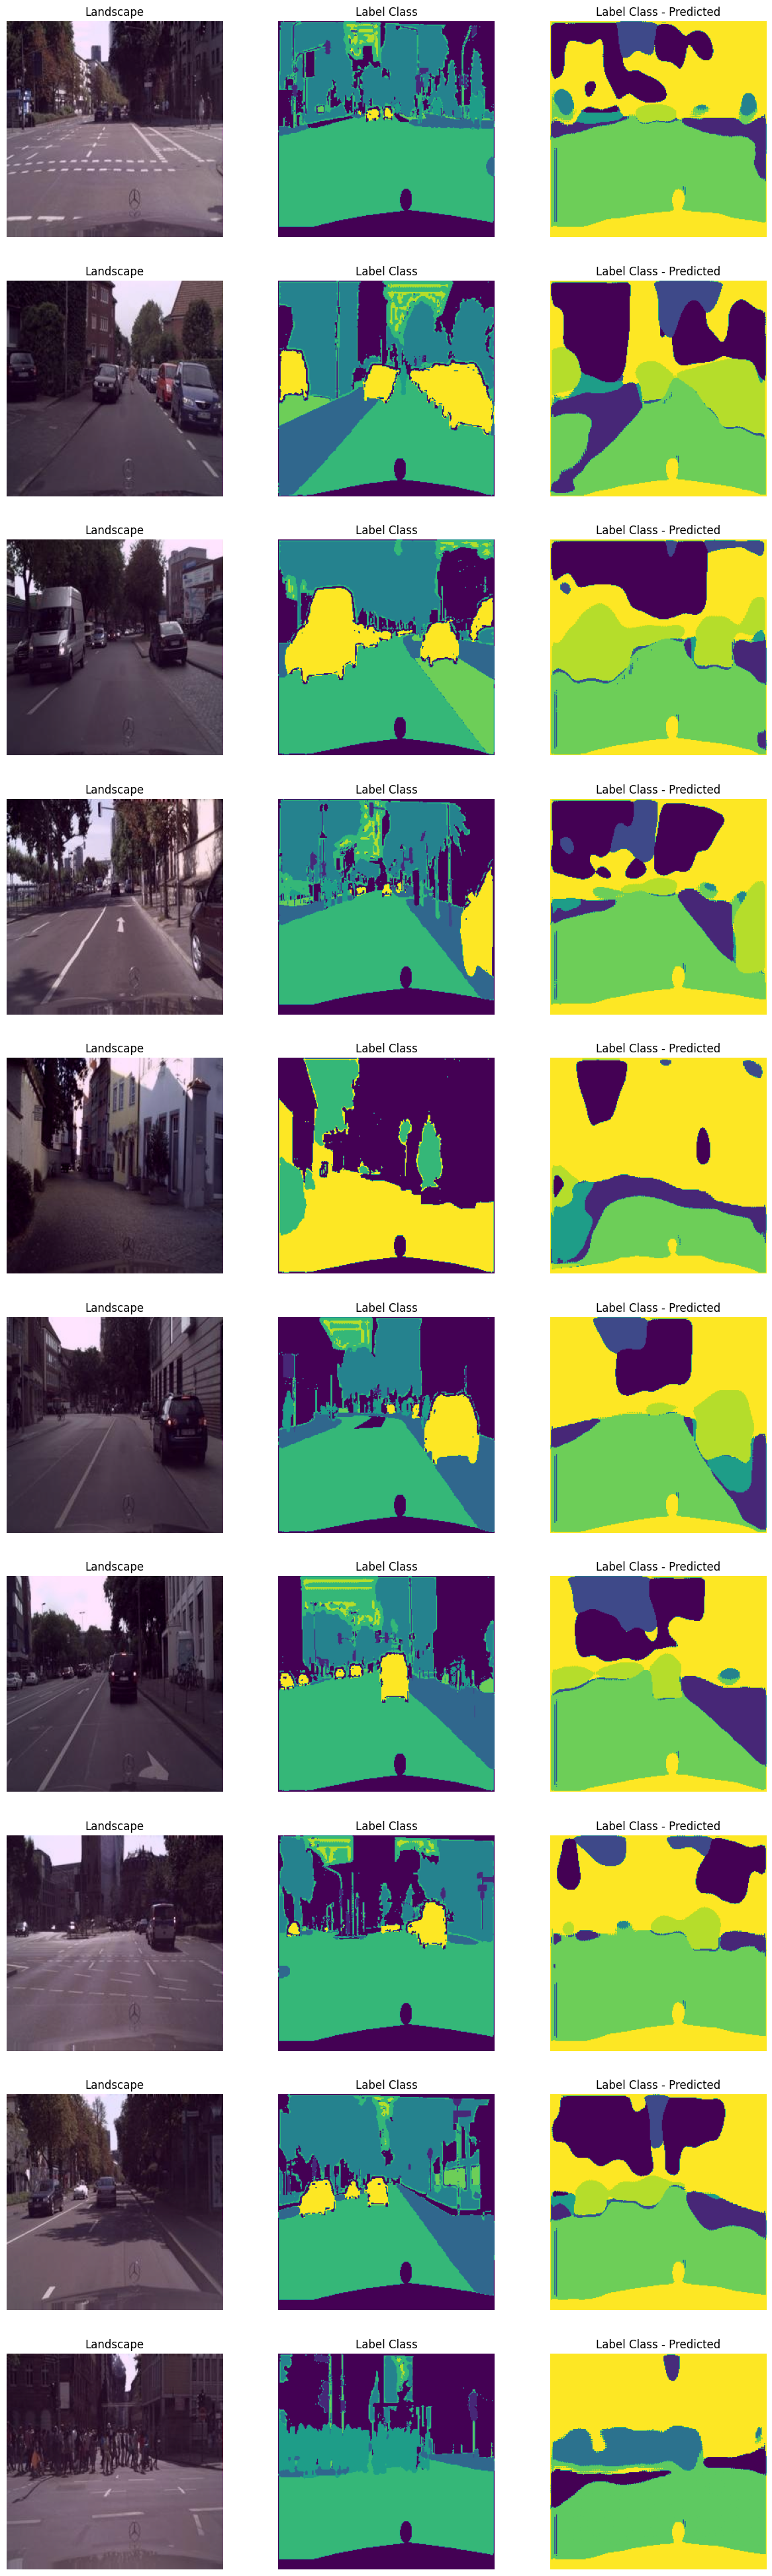

In [52]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

iou_scores = []

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    iou_score = compute_iou(label_class_predicted, label_class, num_classes)
    print(f"Image : {i} | Mean IOU : {iou_score}")
    iou_scores.append(iou_score)
    
    # IOU score
    # intersection = np.logical_and(label_class, label_class_predicted)
    # union = np.logical_or(label_class, label_class_predicted)
    # iou_score = np.sum(intersection) / np.sum(union)
    # iou_scores.append(iou_score)

    axes[i, 0].imshow(landscape)
    axes[i, 0].axis('off')
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].axis('off')
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].axis('off')
    axes[i, 2].set_title("Label Class - Predicted")

In [53]:
print(f"Mean IOU Score : {np.mean(iou_scores)}")

Mean IOU Score : 0.014997660614493317
